# Loan Default Prediction
Author: Alice Zhou

Machine learning techniques are increasingly being used in the loan default prediction. When constructing a predictive model, it is important to use different methods to improve the model performance and therefore decrease the costs of loan default detection. 
- Objectives: This report uses a hypothetical loan dataset for loan default prediction. By using supervised machine learning (Random Forest), different methods (inlcuding feature engineering, sampling methods, and hyper-parameters tuning) will be tested to improve the model performance. 
- Dataset: The dataset contains information on loan application details, borrower's credit history from Credit Bureau, borrower's financial query records, borrower's call records, and third-party data. 

# Table of Contents
- [1. Data Preparation](#1)
- [2. Random Forest Modeling](#2)
    - [2.1 Build Model](#21)
    - [2.2 Model Performance](#22)
    - [2.3 Variable Importance](#23)
- [3. Feature Engineering](#3)
    - [3.1 Feature Selection](#31)
        - [3.1.1 Iterate Model](#311)
        - [3.1.2 Model Performance](#312)
    - [3.2 Special Values Handling](#32)
    - [3.3 WOE](#33)
        - [3.3.1 Iterate Model](#331)
        - [3.3.2 Model Performance](#332)
- [4. Hyperparameter Tuning](#4)
    - [4.1 'balance_classes' of H2O](#41)
        - [4.1.1 Iterate Model](#411)
        - [4.1.2 Model Performance](#412)
- [5. Sampling Methods](#5)
    - [5.1 Undersampling](#51)
        - [5.1.1 Iterate Model](#511)
        - [5.1.2 Model Performance](#512)
    - [5.2 Oversampling](#52)
        - [5.2.1 Iterate Model](#521)
        - [5.2.2 Model Performance](#522)
- [6. Conclusion](#6)

## 1. Data Preparation <a class="anchor" id="1"></a>

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = '/Users/alicezhou/Documents/Columbia/5420 Anomaly Detection/8. Modeling Strategies & Supervised ML/Assignment8/'
df = pd.read_csv(path + 'XYZloan_default_selected_vars.csv') 

Some basic understandings of the raw data:
- Each raw is a borrower (id), and the other variables are the information related to this borrower.
- For the loan default predictive model, "loan_default" is the target variable.
- There are more than 80 variables that can be used as input variables.

In [3]:
# Get the Simple Summary Statistics 
df.describe() 

,Unnamed: 0.1,Unnamed: 0,id,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,...,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,...,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.00000,79619.000000,79619.000000,77207.000000
mean,39999.500000,40000.500000,40000.500000,0.193600,31.706913,1.321813,2.014925,11.235413,3.30130,3.117200,...,6.911956,14.271694,11.773358,909.089313,810.786219,1732.693314,1539.33443,2513.226491,2229.606137,5.976272
std,23094.155105,23094.155105,23094.155105,0.395121,7.075070,0.467174,1.196806,2.212313,1.33655,1.306335,...,28.007499,38.235012,33.270641,1379.553332,1245.044602,2441.503517,2172.71384,3404.975112,3005.615048,3.641814
min,0.000000,1.000000,1.000000,0.000000,20.000000,1.000000,1.000000,3.000000,1.00000,1.000000,...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.00000,-99.000000,-99.000000,0.000000
25%,19999.750000,20000.750000,20000.750000,0.000000,27.000000,1.000000,1.000000,12.000000,2.00000,2.000000,...,2.000000,5.000000,4.000000,84.000000,34.000000,309.000000,226.00000,539.000000,414.000000,3.000000
50%,39999.500000,40000.500000,40000.500000,0.000000,30.000000,1.000000,1.000000,12.000000,3.00000,3.000000,...,7.000000,12.000000,10.000000,475.000000,397.000000,1023.000000,870.00000,1553.000000,1324.000000,5.000000
75%,59999.250000,60000.250000,60000.250000,0.000000,35.000000,2.000000,3.000000,12.000000,5.00000,4.000000,...,14.000000,23.000000,20.000000,1209.000000,1080.000000,2287.000000,2030.00000,3296.000000,2936.000000,8.000000
max,79999.000000,80000.000000,80000.000000,1.000000,56.000000,2.000000,6.000000,12.000000,5.00000,5.000000,...,1061.000000,2792.000000,1579.000000,48585.000000,29664.000000,88364.000000,54651.00000,125352.000000,87312.000000,47.000000


From the variable statistics, we can see that there are some special values (eg. -99) in some variables (eg. CD172, CD173). I will investigate what other special values and create categories to distinct them later. 

In [4]:
# Train test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.40, random_state=42)

In [5]:
train.shape

(48000, 89)

In [6]:
# Categorize the variables' data source
var = pd.DataFrame(train.dtypes).reset_index()
var.columns = ['varname','dtype'] 
var['source'] = var['varname'].str[:2]
var.head(10)

,varname,dtype,source
0,Unnamed: 0.1,int64,Un
1,Unnamed: 0,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP
5,AP002,int64,AP
6,AP003,int64,AP
7,AP004,int64,AP
8,AP005,object,AP
9,AP006,object,AP


In [7]:
# Investigate variables' data type 
var['dtype'].value_counts()

float64    58
int64      28
object      3
Name: dtype, dtype: int64

In [8]:
# There are 3 categorical variables, and the other are numeric variables
var[var['dtype']=='object']

,varname,dtype,source
8,AP005,object,AP
9,AP006,object,AP
88,MB007,object,MB


In [9]:
# Summarize the data source
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

In [10]:
# "AP005" is dropped since it's a timestamp data, which cannot be employed in tree-based methods
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP005')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP004', 'AP006', 'AP007', 'AP008', 'AP009']

In [11]:
# Distribution of bad (1) and good (0) loans
train['loan_default'].value_counts(dropna=False)

0    38736
1     9264
Name: loan_default, dtype: int64

It is clearly that target variable (loan_default) has very imbalanced distribution, which will be considered for model tuning later.

In [12]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 hours 57 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_alicezhou_pb8gh5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


## 2. Random Forest Modeling <a class="anchor" id="2"></a>

Random Forest is suitable for loan default prediction for several reasons:

- Handling Imbalanced Data: Loan default prediction datasets are often imbalanced, with a significantly higher number of non-defaulting loans compared to defaulting loans. Random Forest can handle imbalanced data well because it aggregates multiple decision trees, and during the tree-building process, it gives equal importance to each class in the dataset.

- Non-linearity in Data: Loan default prediction datasets usually involve complex relationships and interactions among various features. Random Forest can capture non-linear relationships effectively since each decision tree in the forest is capable of modeling non-linear patterns independently, and the forest combines them to produce a more accurate prediction.

- Feature Importance: Random Forest provides a feature importance measure that helps identify the most critical features influencing the loan default prediction. This information is valuable for feature selection and understanding which factors have the most impact on the prediction.

- Reducing Overfitting: Random Forest is less prone to overfitting compared to individual decision trees, especially when the number of trees in the forest is set appropriately. By averaging the predictions of multiple trees, it reduces the risk of memorizing noise in the data.

- Scalability: Random Forest can handle large datasets efficiently, and its parallel processing capability allows it to scale well with multi-core processors.

Overall, Random Forest is a powerful and versatile algorithm that can be effectively used for loan default prediction due to its ability to handle complex data, deal with imbalanced classes, and provide insights into feature importance, among other benefits.

For the modeling part, I will run with a small sample dataset first, and then try to write repeating code in a function. 

In [13]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

target='loan_default'

In [14]:
# Sample 10% of the original train and test datasets 
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)

# Convert sampled DataFrames into H2OFrame objects
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [16]:
# Build random forest model for sample data
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v1.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         108037                 6            11           7.83333       19            26            22.5867

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14644283588020868
RMSE: 0.38267850198333414
MAE: 0.29440708975833124
RMSLE: 0.26815423709968583
Mean Residual Deviance: 0.14644283588020868

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.1467305033499564
RMSE: 0.3830541780870643
MAE: 0.2948844725841675
RMSLE: 0.2684436626419797
Mean Residual Deviance: 0.1467305033499564

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.29476    0.0104188   0.288903      0.287341      0.297858      0.299802      0.291677      0.313798      0.284265      0.297221      0.279939      0.306793
mean_residual_deviance  0.146581   0.0114949   0.140082      0.140037      0.15123       0.15228       0.145063      0.166597      0.131871      0.148425      0.130568      0.159654
mse                     0.146581   0.0114949   0.140082      0.140037      0.15123       0.15228       0.145063      0.166597      0.131871      0.148425      0.130568      0.159654
r2                      0.0354389  0.0146672   0.0149073     0.0495227     0.0462994     0.0424208     0.0571598     0.0328469     0.0183929     0.0177226     0.032191      0.0429257
residual_deviance       0.146581   0.0114949   0.140082      0.140037      0.15123       0.15228       0.145063      0.166597      0.131871      0.148425      0.130568      0.159654
rmse                    0.382595   0.0149789   0.374275      0.374216      0.388883      0.39023       0.380871      0.408163      0.363141      0.385259      0.361341      0.399567
rmsle                   0.26826    0.00771416  0.265031      0.262681      0.2708        0.271883      0.266167      0.281901      0.259377      0.270989      0.25704       0.27673

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-07-21 22:35:02  9.511 sec   0.0                nan                  nan                  nan
     2023-07-21 22:35:02  9.516 sec   1.0                0.39499777575729833  0.2978790180759761   0.15602324285321295
     2023-07-21 22:35:02  9.519 sec   2.0                0.3957686030686621   0.29719542863653126  0.1566327871749202
     2023-07-21 22:35:02  9.523 sec   3.0                0.3910897072612402   0.29321441477889537  0.15295115912568258
     2023-07-21 22:35:02  9.527 sec   4.0                0.39016867855685494  0.29384854234592844  0.1522315977268024
     2023-07-21 22:35:02  9.530 sec   5.0                0.3897549207912031   0.2950070988203399   0.151908898280957
     2023-07-21 22:35:02  9.534 sec   6.0                0.38946159180729695  0.29538536670232285  0.15168033149307358
     2023-07-21 22:35:02  9.537 sec   7.0                0.38754024560072664  0.2944811792337709   0.15018744196027153
     2023-07-21 22:35:02  9.541 sec   8.0                0.3860624451455912   0.29368931136602605  0.1490442115517926
     2023-07-21 2

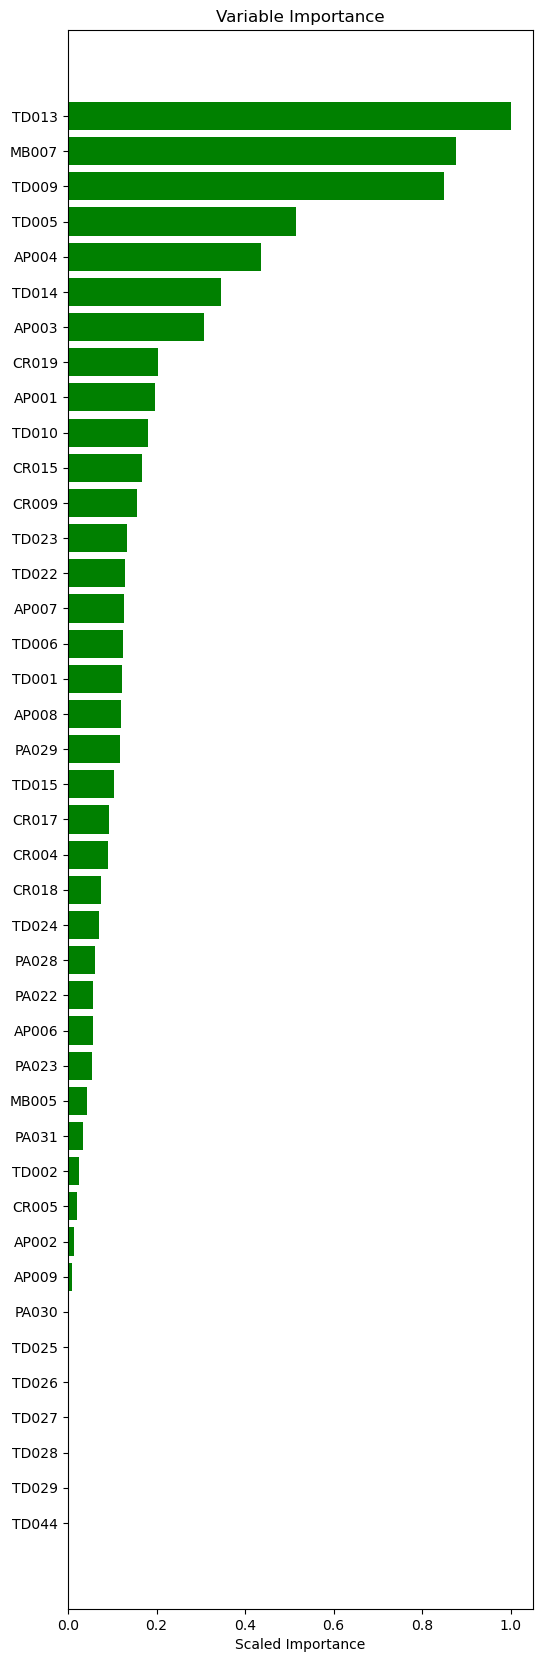

In [17]:
# Create a function to show the variable importance 
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
VarImp(rf_v1)

In [18]:
# Comparison between model predictions and actual target values
predictions = rf_v1.predict(test_hex)
predictions.head()
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,loan_default,predict
0,0,0.276288
1,0,0.158607
2,0,0.122713
3,0,0.225707
4,0,0.119204


In [19]:
# Create a function to generate gains table and show the cumulative lift
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(rf_v1)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,113,207,320,113,207,0.19,0.08,60.0,1.88,11.0,35.31
1,320,93,227,640,206,434,0.34,0.17,120.0,1.72,17.0,32.19
2,320,75,245,960,281,679,0.47,0.26,180.0,1.56,21.0,29.27
3,320,65,255,1280,346,934,0.58,0.36,240.0,1.44,22.0,27.03
4,320,60,260,1600,406,1194,0.68,0.46,300.0,1.35,22.0,25.37
5,320,44,276,1920,450,1470,0.75,0.57,360.0,1.25,18.0,23.44
6,320,38,282,2240,488,1752,0.81,0.67,420.0,1.16,14.0,21.79
7,320,52,268,2560,540,2020,0.90,0.78,480.0,1.12,12.0,21.09
8,320,37,283,2880,577,2303,0.96,0.89,540.0,1.07,7.0,20.03


In [20]:
# Create a function to plot the ROC curve and precision-recall curve
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



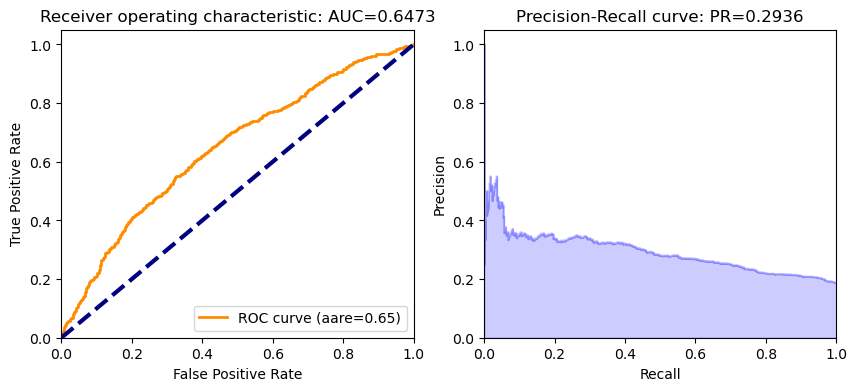

In [21]:
ROC_AUC(rf_v1,test_hex,'loan_default')

### 2.1 Build Model <a class="anchor" id="21"></a>

Now the code works fine with the small dataset, we can model with the entire dataset¶

In [22]:
# Convert entire train & test DataFrames into H2OFrame objects
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [23]:
# Build random forest models with all the original variables and default hyperparameters
rf_v2 = H2ORandomForestEstimator(
        model_id = 'rf_v2',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v2.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         957884                 13           19           15.49         216           233           225.25

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.1459313097139393
RMSE: 0.3820095675685876
MAE: 0.2937373175432457
RMSLE: 0.2676862477574358
Mean Residual Deviance: 0.1459313097139393

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14602212309672283
RMSE: 0.3821284117894439
MAE: 0.29404839811055467
RMSLE: 0.2677657674613577
Mean Residual Deviance: 0.14602212309672283

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.294048   0.00386198  0.292838      0.29192       0.296777      0.298618      0.29645       0.286151      0.290835      0.29842       0.295299      0.293168
mean_residual_deviance  0.146022   0.00398202  0.143549      0.143271      0.148801      0.14995       0.149694      0.138966      0.141762      0.150203      0.148595      0.14543
mse                     0.146022   0.00398202  0.143549      0.143271      0.148801      0.14995       0.149694      0.138966      0.141762      0.150203      0.148595      0.14543
r2                      0.0622212  0.00704605  0.0690052     0.0561253     0.0669404     0.0707195     0.0538554     0.0713984     0.059842      0.0564257     0.05374       0.0641601
residual_deviance       0.146022   0.00398202  0.143549      0.143271      0.148801      0.14995       0.149694      0.138966      0.141762      0.150203      0.148595      0.14543
rmse                    0.382096   0.0052264   0.378879      0.378512      0.385747      0.387234      0.386903      0.372781      0.376513      0.387561      0.38548       0.381352
rmsle                   0.267753   0.0029207   0.266053      0.266217      0.269391      0.270087      0.2706        0.261949      0.265101      0.270936      0.269825      0.267372

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2023-07-21 22:36:36  1 min 28.529 sec  0.0                nan                  nan                  nan
     2023-07-21 22:36:36  1 min 28.561 sec  1.0                0.39088548532874856  0.29508646310827813  0.1527914626406913
     2023-07-21 22:36:36  1 min 28.591 sec  2.0                0.3881935491796874   0.29371197389339565  0.15069423162472237
     2023-07-21 22:36:37  1 min 28.620 sec  3.0                0.3868815655888834   0.2935871014838132   0.14967734579250552
     2023-07-21 22:36:37  1 min 28.651 sec  4.0                0.38671986718585166  0.2938749598535999   0.14955225567624275
     2023-07-21 22:36:37  1 min 28.677 sec  5.0                0.38617080632459144  0.2939341305208753   0.14912789165738513
     2023-07-21 22:36:37  1 min 28.700 sec  6.0                0.3856161697515466   0.2937847608489159   0.14869983037385362
     2023-07-21 22:36:37  1 min 28.726 sec  7.0                0.38515604721708296  0.2936697898472897   0.14834518070788782
     2023-07-21 22:36:37  1 min 28.752 sec  8.0                0.385109994787

### 2.2 Model Performance <a class="anchor" id="22"></a>

In loan default prediction, the model's performance is evaluated using different metrics, such as AUC (Area Under the Receiver Operating Characteristic Curve), PR (Precision-Recall), and Gains Table.

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



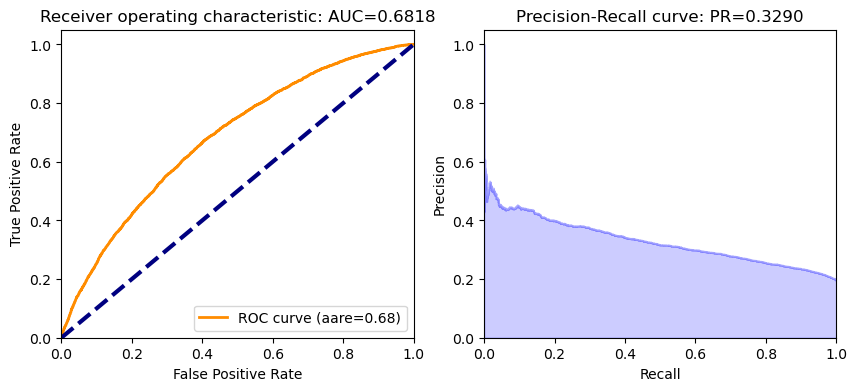

In [24]:
ROC_AUC(rf_v2,test_hex,'loan_default')

AUC (Area Under the Curve): AUC is a popular metric for evaluating binary classification models. It measures the model's ability to distinguish between positive and negative samples. An AUC value of 0.6818 indicates that the model has moderate discriminatory power, but there is room for improvement. The AUC ranges from 0 to 1, where 0.5 represents random guessing, and 1 represents a perfect classifier.

PR (Precision-Recall): PR is another metric used for binary classification, especially when dealing with imbalanced datasets. It focuses on the trade-off between precision (positive predictive value) and recall (sensitivity or true positive rate). The PR value of 0.3290 indicates that the model's precision is relatively low compared to its recall. This means that while the model can identify a good proportion of actual loan defaults (high recall), it may also produce a considerable number of false positives (low precision).

In [25]:
createGains(rf_v2)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1273,1927,3200,1273,1927,0.20,0.07,622.4,2.05,13.0,39.78
1,3200,983,2217,6400,2256,4144,0.36,0.16,1244.8,1.81,20.0,35.25
2,3200,804,2396,9600,3060,6540,0.49,0.25,1867.2,1.64,24.0,31.87
3,3200,740,2460,12800,3800,9000,0.61,0.35,2489.6,1.53,26.0,29.69
4,3200,617,2583,16000,4417,11583,0.71,0.45,3112.0,1.42,26.0,27.61
5,3200,517,2683,19200,4934,14266,0.79,0.55,3734.4,1.32,24.0,25.70
6,3200,465,2735,22400,5399,17001,0.87,0.66,4356.8,1.24,21.0,24.10
7,3200,384,2816,25600,5783,19817,0.93,0.77,4979.2,1.16,16.0,22.59
8,3200,278,2922,28800,6061,22739,0.97,0.88,5601.6,1.08,9.0,21.05


Gains Table:

The gains table provides additional insights into how the model performs across different deciles. A decile represents a grouping of samples based on their predicted probabilities. The gains table shows the cumulative count of actual and non-actual (predicted) loan defaults for each decile, along with various evaluation metrics.

Key Metrics in the Gains Table:

- Cumulative Actual: Cumulative count of actual loan defaults observed in each decile.
- Cumulative Non-Actual: Cumulative count of non-defaults observed in each decile.
- Percent Cumulative Actual: Percentage of cumulative actual loan defaults relative to the total number of actual loan defaults.
- Percent Cumulative Non-Actual: Percentage of cumulative non-defaults relative to the total number of non-defaults.
- Lift: Lift measures how many times better the model performs compared to a random model. It is calculated as the ratio of the percent cumulative actual to the percent cumulative non-actual.
- K-S: The Kolmogorov-Smirnov statistic measures the maximum distance between the cumulative distribution functions of the actual and non-actual groups. It is a measure of the model's discriminatory power.
- Gain: The gain is the cumulative percentage of actual loan defaults at each decile. It shows how much of the total default population is captured at each decile.

Interpretation:

From the gains table, we can observe the model's performance at different deciles. The higher the decile, the higher the predicted probabilities of loan default. The gain and lift metrics show how much better the model is performing compared to random selection at each decile. The K-S metric indicates the maximum difference in cumulative percentages between actual and non-actual groups.

Overall, the model seems to perform reasonably well in identifying loan defaults, especially in higher deciles, where the gain is relatively higher. However, there is still room for improvement, especially in terms of precision (PR) and discriminatory power (AUC). Further analysis and model tuning may help improve the model's performance.

### 2.3 Variable Importance <a class="anchor" id="23"></a>

I am going to plot the variable importance for initial feature selection. 

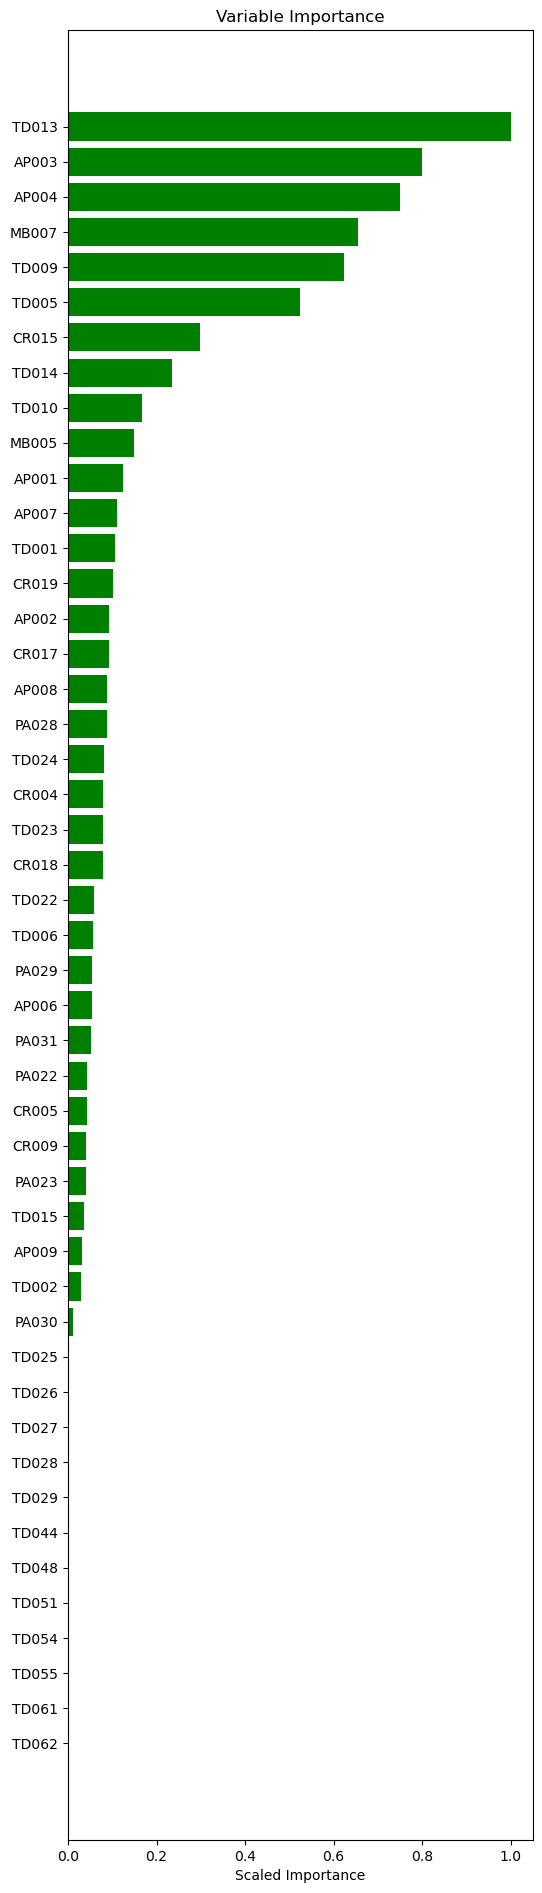

In [26]:
VarImp(rf_v2)

We can see that around 40 variables are shown significantly important to the model performance. My initial thought is to drop the other variables (scaled importance = 0) and see whether it can improve model performance.

## 3. Feature Engineering <a class="anchor" id="3"></a>

### 3.1 Feature Selection <a class="anchor" id="31"></a>

In [27]:
# Build a dataframe to show the variables importance 
varimportance_df=rf_v2._model_json['output']['variable_importances'].as_data_frame()
varimportance_df

,variable,relative_importance,scaled_importance,percentage
0,TD013,18831.277344,1.000000,0.145479
1,AP003,15036.323242,0.798476,0.116161
2,AP004,14104.791016,0.749009,0.108965
3,MB007,12329.631836,0.654742,0.095251
4,TD009,11751.776367,0.624056,0.090787
5,TD005,9850.624023,0.523099,0.076100
6,CR015,5596.253418,0.297179,0.043233
7,TD014,4428.792480,0.235183,0.034214
8,TD010,3168.823486,0.168274,0.024480
9,MB005,2800.253662,0.148702,0.021633


In [28]:
# Select those significantly important variables as predictors 
predictors2 = varimportance_df[varimportance_df['scaled_importance']!=0]['variable'].tolist()

#### 3.1.1 Iterate Model <a class="anchor" id="311"></a>

In [29]:
# Build random forest model with selected features
rf_v3 = H2ORandomForestEstimator(
        model_id = 'rf_v3',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v3.train(predictors2,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v3


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         942109                 13           19           15.5633       214           235           223.46

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14599435704140332
RMSE: 0.38209207927069533
MAE: 0.29428324238824616
RMSLE: 0.26768834624585647
Mean Residual Deviance: 0.14599435704140332

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14608402478550983
RMSE: 0.3822093991328704
MAE: 0.2945617148962336
RMSLE: 0.26777093757912207
Mean Residual Deviance: 0.14608402478550983

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.294561   0.00387198  0.293489      0.292331      0.297156      0.299229      0.296954      0.286749      0.29113       0.29895       0.295897      0.293726
mean_residual_deviance  0.146084   0.00400563  0.143782      0.143221      0.14881       0.150104      0.149757      0.139056      0.141677      0.150294      0.148704      0.145433
mse                     0.146084   0.00400563  0.143782      0.143221      0.14881       0.150104      0.149757      0.139056      0.141677      0.150294      0.148704      0.145433
r2                      0.0618286  0.00683347  0.0674965     0.0564548     0.0668852     0.0697623     0.0534545     0.0707939     0.0604033     0.0558564     0.0530412     0.0641383
residual_deviance       0.146084   0.00400563  0.143782      0.143221      0.14881       0.150104      0.149757      0.139056      0.141677      0.150294      0.148704      0.145433
rmse                    0.382177   0.00525597  0.379185      0.378446      0.385759      0.387433      0.386985      0.372902      0.376401      0.387678      0.385622      0.381357
rmsle                   0.267758   0.00293751  0.266226      0.266095      0.269334      0.2702        0.270591      0.262015      0.264934      0.27098       0.26989       0.267318

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2023-07-21 22:38:10  1 min 23.032 sec  0.0                nan                  nan                  nan
     2023-07-21 22:38:10  1 min 23.050 sec  1.0                0.39095349136370394  0.29572445298619937  0.15284463240946972
     2023-07-21 22:38:10  1 min 23.068 sec  2.0                0.38844048010544263  0.29387006689390843  0.1508860065845468
     2023-07-21 22:38:10  1 min 23.087 sec  3.0                0.38694994080407463  0.2939227820492003   0.14973025668827686
     2023-07-21 22:38:10  1 min 23.108 sec  4.0                0.38622354229614997  0.2939824332750755   0.14916862462378594
     2023-07-21 22:38:10  1 min 23.128 sec  5.0                0.3858837255470094   0.2939753055089484   0.1489062496420397
     2023-07-21 22:38:10  1 min 23.148 sec  6.0                0.38515727375543146  0.29353922535966637  0.14834612552671636
     2023-07-21 22:38:10  1 min 23.167 sec  7.0                0.3848927891929123   0.2938047891653141   0.14814245917269964
     2023-07-21 22:38:10  1 min 23.186 sec  8.0                0.38484

#### 3.1.2 Model Performance <a class="anchor" id="312"></a>

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



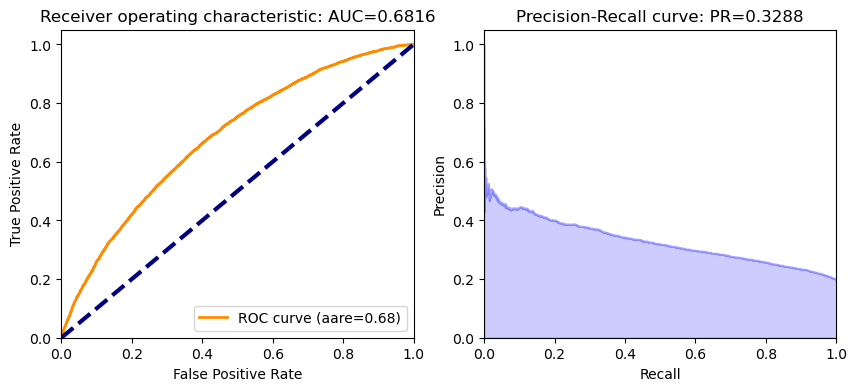

In [30]:
ROC_AUC(rf_v3,test_hex,'loan_default')

Both AUC (0.6816 < 0.6818) and PR (0.3288 < 0.3290) are decreased after feature selection. The model performance cannot be improved by simply selecting those important variables.

In [31]:
createGains(rf_v3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1274,1926,3200,1274,1926,0.20,0.07,622.4,2.05,13.0,39.81
1,3200,976,2224,6400,2250,4150,0.36,0.16,1244.8,1.81,20.0,35.16
2,3200,820,2380,9600,3070,6530,0.49,0.25,1867.2,1.64,24.0,31.98
3,3200,711,2489,12800,3781,9019,0.61,0.35,2489.6,1.52,26.0,29.54
4,3200,622,2578,16000,4403,11597,0.71,0.45,3112.0,1.41,26.0,27.52
5,3200,550,2650,19200,4953,14247,0.80,0.55,3734.4,1.33,25.0,25.80
6,3200,442,2758,22400,5395,17005,0.87,0.66,4356.8,1.24,21.0,24.08
7,3200,384,2816,25600,5779,19821,0.93,0.77,4979.2,1.16,16.0,22.57
8,3200,283,2917,28800,6062,22738,0.97,0.88,5601.6,1.08,9.0,21.05


By comparing the cumulative lift between rf_v3 and rf_v2, the previous model shows better performance, since most of the cumulative lifts are larger. The model performance cannot be improved by simply selecting those important variables. Therefore, I will include all the variables for coming feature engineering and model iteration.

### 3.2 Special Values Handling <a class="anchor" id="32"></a>

Next, I will investigate the special values, including missing values (NA), '-99', '-98', '-1'.

In [32]:
# Check missing values
varmissing_df = df[predictors].isnull().sum().to_frame(name='Missing Values').reset_index().rename(columns={'index': 'Variable'})
var_to_WOE1 =varmissing_df[varmissing_df['Missing Values']!=0]['Variable'].tolist()
var_to_WOE1

['TD022',
 'TD023',
 'TD024',
 'TD025',
 'TD026',
 'TD027',
 'TD028',
 'TD029',
 'TD044',
 'TD048',
 'TD051',
 'TD054',
 'TD055',
 'TD061',
 'TD062',
 'MB005',
 'PA022',
 'PA023',
 'PA028',
 'PA029',
 'PA030',
 'PA031']

In [33]:
# Check whether minimum values cover negative values like '-99' 
df[predictors].describe().loc['min']

CR004     1.0
CR005     1.0
CR009     0.0
CR012     0.0
CR015     2.0
CR017     1.0
CR018     0.0
CR019     1.0
TD001     0.0
TD002     0.0
TD005     0.0
TD006     0.0
TD009     0.0
TD010     0.0
TD013     0.0
TD014     0.0
TD015     0.0
TD022    10.0
TD023     0.0
TD024     0.0
TD025     0.0
TD026     0.0
TD027     0.0
TD028     0.0
TD029     6.0
TD044    20.0
TD048    60.0
TD051    20.0
TD054    60.0
TD055    30.0
TD061     2.0
TD062    30.0
AP001    20.0
AP002     1.0
AP003     1.0
AP004     3.0
AP007     1.0
AP008     1.0
AP009     0.0
MB005     0.0
CR004     1.0
CR005     1.0
CR009     0.0
CR012     0.0
CR015     2.0
CR017     1.0
CR018     0.0
CR019     1.0
PA022   -99.0
PA023   -99.0
PA028   -99.0
PA029   -99.0
PA030   -99.0
PA031   -99.0
Name: min, dtype: float64

‘-99’, '-98' and '-1' are very likely missing values and set by the systems as extreme values. In a parametric regression, we can not use them blindly as numeric values. I am going to bin the continuous variable, leaving the special values ‘-99’, '-98', ‘-1’, and’NA’ as their categories. These numeric variables will be converted to catogorical variables and I will then conduct WOE transformation for these catogorical variables for better capture their patterns.

In [34]:
# Check the other special variables
print(sum(df['PA022']==-99))
print(sum(df['PA022']==-98))
print(sum(df['PA022']==-1))
print(sum(df['PA022']<0))

1534
0
50639
52173


In [35]:
# Check the other special variables
print(sum(df['PA023']==-99))
print(sum(df['PA023']==-98))
print(sum(df['PA023']==-1))
print(sum(df['PA023']<0))

1534
0
56004
57538


In [36]:
# Check the other special variables
print(sum(df['PA028']==-99))
print(sum(df['PA028']==-98))
print(sum(df['PA028']==-1))
print(sum(df['PA028']<0))

1534
50639
0
52173


In [37]:
# Check the other special variables
print(sum(df['PA029']==-99))
print(sum(df['PA029']==-98))
print(sum(df['PA029']==-1))
print(sum(df['PA029']<0))

1534
53086
0
54620


In [38]:
# Check the other special variables
print(sum(df['PA030']==-99))
print(sum(df['PA030']==-98))
print(sum(df['PA030']==-1))
print(sum(df['PA030']<0))

1534
67886
0
69420


In [39]:
# Check the other special variables
print(sum(df['PA031']==-99))
print(sum(df['PA031']==-98))
print(sum(df['PA031']==-1))
print(sum(df['PA031']<0))

1534
56004
0
57538


I will include the categorical variables for future WOE transformation as well.

In [40]:
# Extract categorical variables
var_to_WOE_cat = var[var['dtype']=='object']['varname'].tolist()
var_to_WOE_cat

['AP005', 'AP006', 'MB007']

I will also include 'AP002' (CODE_GENDER) and 'AP003' (CODE_EDUCATION) for WOE transformation because these variables are also categorical information. 

In [41]:
var_to_WOE_num = var_to_WOE1 + ['AP002', 'AP003']
var_to_WOE_num

['TD022',
 'TD023',
 'TD024',
 'TD025',
 'TD026',
 'TD027',
 'TD028',
 'TD029',
 'TD044',
 'TD048',
 'TD051',
 'TD054',
 'TD055',
 'TD061',
 'TD062',
 'MB005',
 'PA022',
 'PA023',
 'PA028',
 'PA029',
 'PA030',
 'PA031',
 'AP002',
 'AP003']

In [42]:
# Bin the continuous variable
def binning(df, var):
    # Check for missing values and replace with a default value if necessary
    df[var] = df[var].fillna("-999")

    # Convert the column to a numeric type (if it is not already)
    df[var] = pd.to_numeric(df[var], errors='coerce')

    # Check if the column contains NaN values after conversion
    if df[var].isnull().any():
        print(f"Warning: {var} contains NaN values after conversion. Check the data.")

    # Perform qcut on the numeric data
    if not df[var].empty:
        df[var + '_bin'] = pd.qcut(df[var], 10, duplicates='drop').values.add_categories("NoData")
        df[var + '_bin'] = df[var + '_bin'].fillna("NoData").astype(str)
        df[var + '_bin'].value_counts(dropna=False)
    
    # Handle specific values like -99, -98, and -1
    df.loc[df[var] == -999, var + '_bin'] = "NoData"
    df.loc[df[var] == -99, var + '_bin'] = -99
    df.loc[df[var] == -98, var + '_bin'] = -98
    df.loc[df[var] == -1, var + '_bin'] = -1

# Apply binning to train and test data
for i in var_to_WOE_num:
    binning(train, i)
    binning(test, i)

var_to_WOE_num_bin = [f + '_bin' for f in var_to_WOE_num]
features_bin = var_to_WOE_num_bin + list(var_to_WOE_cat)

### 3.3 WOE <a class="anchor" id="33"></a>

In [43]:
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(df, test_size=0.40, random_state=42)

Weight of evidence (WOE) transformation is a widely used technique in credit risk modeling or called the probability of default modeling (such models predict how capable an applicant can repay the loan). The goal of WOE transformation is to get the maximum difference among the binned categories relating to the target variable. In this transformation, the information of the target variable has been utilized. The dataset contains many categorical variables with many categories. These categories are distributed very differently are have various significant impact to the possibility of default as discussed above. Therefore, WOE is a good choice for feature engineering here.

In [44]:
# Calculate WOE for each category 
import category_encoders as ce

ec = ce.WOEEncoder()

def WOE(df, var):
    df[var] = df[var].fillna('NoData')
    X = df[var]
    y = df['loan_default']
    X_WOE = ec.fit(X, y)
    X_cleaned = ec.transform(X).round(2)
    df[var + '_WOE'] = X_cleaned 
    
for i in features_bin:
    WOE(train, i)  
    WOE(test, i)

In [45]:
# After WOE transformation, the original variables will be replaced by their WOE 
var_to_drop = var_to_WOE_num + var_to_WOE_cat
var_WOE = train.filter(like='_WOE').columns.tolist()

In [46]:
# Predictors will be the original variables without WOE transformation and new WOE variables
predictors3 = [x for x in predictors if x not in var_to_drop]
predictors3 = predictors3 + var_WOE
predictors3

['CR004',
 'CR005',
 'CR009',
 'CR012',
 'CR015',
 'CR017',
 'CR018',
 'CR019',
 'TD001',
 'TD002',
 'TD005',
 'TD006',
 'TD009',
 'TD010',
 'TD013',
 'TD014',
 'TD015',
 'AP001',
 'AP004',
 'AP007',
 'AP008',
 'AP009',
 'CR004',
 'CR005',
 'CR009',
 'CR012',
 'CR015',
 'CR017',
 'CR018',
 'CR019',
 'TD022_bin_WOE',
 'TD023_bin_WOE',
 'TD024_bin_WOE',
 'TD025_bin_WOE',
 'TD026_bin_WOE',
 'TD027_bin_WOE',
 'TD028_bin_WOE',
 'TD029_bin_WOE',
 'TD044_bin_WOE',
 'TD048_bin_WOE',
 'TD051_bin_WOE',
 'TD054_bin_WOE',
 'TD055_bin_WOE',
 'TD061_bin_WOE',
 'TD062_bin_WOE',
 'MB005_bin_WOE',
 'PA022_bin_WOE',
 'PA023_bin_WOE',
 'PA028_bin_WOE',
 'PA029_bin_WOE',
 'PA030_bin_WOE',
 'PA031_bin_WOE',
 'AP002_bin_WOE',
 'AP003_bin_WOE',
 'AP005_WOE',
 'AP006_WOE',
 'MB007_WOE']

In [47]:
# Convert sampled DataFrames into H2OFrame objects
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


#### 3.2.1 Iterate Model <a class="anchor" id="321"></a>

In [48]:
# Build random forest model with new variables after feature engineering
rf_v4 = H2ORandomForestEstimator(
        model_id = 'rf_v4',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v4.train(predictors3,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v4


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         779385                 14           20           16.74         170           225           201.327

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.12325002402725128
RMSE: 0.3510698278508868
MAE: 0.25437317343463933
RMSLE: 0.24549664499393617
Mean Residual Deviance: 0.12325002402725128

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.12347227839277077
RMSE: 0.3513862239655544
MAE: 0.25516616207517
RMSLE: 0.24568372185736229
Mean Residual Deviance: 0.12347227839277077

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.255177  0.00422871  0.256496      0.252669      0.256115      0.260477      0.25925       0.246087      0.250924      0.256291      0.256197      0.257263
mean_residual_deviance  0.12348   0.00390358  0.122149      0.120739      0.123857      0.12881       0.127912      0.116135      0.119546      0.124655      0.126089      0.124908
mse                     0.12348   0.00390358  0.122149      0.120739      0.123857      0.12881       0.127912      0.116135      0.119546      0.124655      0.126089      0.124908
r2                      0.20703   0.0112658   0.207795      0.204569      0.223351      0.201727      0.191529      0.22396       0.20718       0.216919      0.197056      0.196216
residual_deviance       0.12348   0.00390358  0.122149      0.120739      0.123857      0.12881       0.127912      0.116135      0.119546      0.124655      0.126089      0.124908
rmse                    0.351358  0.00557404  0.349499      0.347475      0.351934      0.358901      0.357648      0.340786      0.345754      0.353065      0.35509       0.353423
rmsle                   0.245673  0.00326311  0.245465      0.243476      0.245217      0.249413      0.249573      0.238945      0.24288       0.246451      0.247614      0.247699

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2023-07-21 22:39:59  1 min 30.926 sec  0.0                nan                  nan                  nan
     2023-07-21 22:39:59  1 min 30.950 sec  1.0                0.37193879947124003  0.26777447751815736  0.13833847055210732
     2023-07-21 22:39:59  1 min 30.971 sec  2.0                0.3625377072427613   0.25865255716007196  0.1314335891728381
     2023-07-21 22:39:59  1 min 30.994 sec  3.0                0.3588710199533827   0.2550923411740252   0.12878840896238122
     2023-07-21 22:39:59  1 min 31.014 sec  4.0                0.3581258380724256   0.25475658525853057  0.12825411589507718
     2023-07-21 22:39:59  1 min 31.037 sec  5.0                0.3587102740023654   0.25679278817896384  0.12867306067485207
     2023-07-21 22:39:59  1 min 31.060 sec  6.0                0.35695631336289446  0.255834058407479    0.12741780964962893
     2023-07-21 22:39:59  1 min 31.080 sec  7.0                0.3558893528843451   0.25478087473470373  0.1266572314964379
     2023-07-21 22:39:59  1 min 31.103 sec  8.0                0.3551874932292911 

#### 3.2.2 Model Performance <a class="anchor" id="322"></a>

With the new feature engineering and WOE transformation, the model's performance has significantly improved compared to the previous model.

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



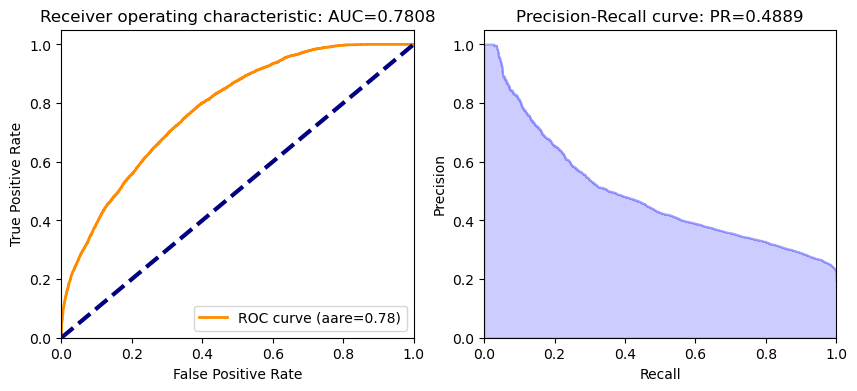

In [49]:
ROC_AUC(rf_v4,test_hex,'loan_default')

AUC (Area Under the Curve): The AUC value of 0.7808 indicates that the model's discriminatory power has substantially increased. A higher AUC value suggests that the model is better at distinguishing between positive and negative samples. An AUC of 0.78 means that the model's ability to correctly rank loan default probabilities is quite good.

PR (Precision-Recall): The PR value of 0.4889 indicates that the model's precision-recall trade-off has also improved. The model is now achieving a higher precision while maintaining good recall. A PR value of 0.49 suggests that the model is better at identifying actual loan defaults while reducing false positives.

In [50]:
createGains(rf_v4)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1779,1421,3200,1779,1421,0.29,0.06,622.4,2.86,23.0,55.59
1,3200,1095,2105,6400,2874,3526,0.46,0.14,1244.8,2.31,32.0,44.91
2,3200,860,2340,9600,3734,5866,0.60,0.23,1867.2,2.00,37.0,38.90
3,3200,743,2457,12800,4477,8323,0.72,0.32,2489.6,1.80,40.0,34.98
4,3200,613,2587,16000,5090,10910,0.82,0.42,3112.0,1.64,40.0,31.81
5,3200,489,2711,19200,5579,13621,0.90,0.53,3734.4,1.49,37.0,29.06
6,3200,369,2831,22400,5948,16452,0.96,0.64,4356.8,1.37,32.0,26.55
7,3200,217,2983,25600,6165,19435,0.99,0.75,4979.2,1.24,24.0,24.08
8,3200,59,3141,28800,6224,22576,1.00,0.88,5601.6,1.11,12.0,21.61


Gains Table:
The gains table provides detailed insights into the model's performance at different deciles. Each decile represents a grouping of samples based on their predicted probabilities.

Interpretation:

The gains table shows that the new model significantly outperforms the previous one. The lift values are consistently higher, indicating that the model is performing much better than random guessing. The K-S values are also higher, showing improved discriminatory power between actual and non-actual groups.

Moreover, the gain values are higher across all deciles, indicating that the model is better at capturing loan defaults compared to the previous model. For example, at the 10th decile, the model captures 55.59% of the total defaults, whereas the previous model captured only 39.78% at the same decile.

Overall, the new model shows marked improvement in both AUC and PR, indicating that it has better predictive performance and is more effective in identifying loan defaults while maintaining higher precision. This model is likely to be more reliable for loan default prediction and can potentially help in making better lending decisions.

## 4. Hyperparameter Tuning <a class="anchor" id="4"></a>

Tuning the 'balance_classes' hyperparameter in a Random Forest model for loan prediction can lead to better model performance, better alignment with business requirements, and improved fairness and interpretability in predictions, especially when dealing with imbalanced data. However, the choice to balance classes should be made based on the specific characteristics of the dataset and the desired outcomes of the loan prediction application.
1. Handling Imbalanced Data: Loan default prediction datasets often suffer from class imbalance, where the number of non-defaulting loans is much higher than the number of defaulting loans. If the class imbalance is not properly addressed, the model may become biased towards the majority class (non-defaulting loans) and perform poorly in predicting the minority class (defaulting loans). Tuning the 'balance_classes' hyperparameter allows you to control how the class imbalance is handled during model training.
2. Impact on Model Performance: Imbalanced data can lead to misleadingly high accuracy metrics because the model may predict the majority class accurately while completely missing the minority class. By balancing the classes during training, you can improve the model's ability to identify and predict the minority class (defaulting loans) correctly, leading to better overall performance metrics such as precision, recall, and F1-score.
3. Avoiding Overfitting: When dealing with imbalanced data, if the model is not balanced appropriately during training, it may overfit to the majority class and fail to generalize well to unseen data. Tuning the 'balance_classes' hyperparameter can help prevent overfitting and improve the model's ability to generalize to new loan samples.
4. Meeting Business Requirements: In many loan prediction scenarios, correctly identifying defaulting loans is of utmost importance to manage risk effectively. Tuning the 'balance_classes' hyperparameter can help ensure that the model's predictions align with business requirements and objectives.
5. Interpretability: Balancing the classes can lead to more interpretable results, as the model is less likely to focus only on the majority class and will consider the influence of both classes on the final prediction.
6. Fairness: In some cases, imbalanced data can introduce bias into the model's predictions. Balancing the classes can help mitigate this bias and ensure fairer predictions for different loan applicants.

### 4.1 'balance_classes' of H2O <a class="anchor" id="41"></a>

The balance_classes option can be used to balance the class distribution. When enabled, H2O will either undersample the majority classes or oversample the minority classes.
Note that the resulting model will also correct the final probabilities (“undo the sampling”) using a monotonic transform, so the predicted probabilities of the first model will differ from a second model. However, because AUC only cares about ordering, it won’t be affected.

#### 4.1.1 Iterate Model <a class="anchor" id="311"></a>

In [51]:
# Set balance_classes = True, and build the random forest model
rf_v5 = H2ORandomForestEstimator(
        model_id = 'rf_v5',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        balance_classes = True,
        seed=1234)
rf_v5.train(predictors3,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v5


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         779393                 14           20           16.74         170           225           201.327

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.12325002402725128
RMSE: 0.3510698278508868
MAE: 0.25437317343463933
RMSLE: 0.24549664499393617
Mean Residual Deviance: 0.12325002402725128

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.12347227839277077
RMSE: 0.3513862239655544
MAE: 0.25516616207517
RMSLE: 0.24568372185736229
Mean Residual Deviance: 0.12347227839277077

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.255177  0.00422871  0.256496      0.252669      0.256115      0.260477      0.25925       0.246087      0.250924      0.256291      0.256197      0.257263
mean_residual_deviance  0.12348   0.00390358  0.122149      0.120739      0.123857      0.12881       0.127912      0.116135      0.119546      0.124655      0.126089      0.124908
mse                     0.12348   0.00390358  0.122149      0.120739      0.123857      0.12881       0.127912      0.116135      0.119546      0.124655      0.126089      0.124908
r2                      0.20703   0.0112658   0.207795      0.204569      0.223351      0.201727      0.191529      0.22396       0.20718       0.216919      0.197056      0.196216
residual_deviance       0.12348   0.00390358  0.122149      0.120739      0.123857      0.12881       0.127912      0.116135      0.119546      0.124655      0.126089      0.124908
rmse                    0.351358  0.00557404  0.349499      0.347475      0.351934      0.358901      0.357648      0.340786      0.345754      0.353065      0.35509       0.353423
rmsle                   0.245673  0.00326311  0.245465      0.243476      0.245217      0.249413      0.249573      0.238945      0.24288       0.246451      0.247614      0.247699

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2023-07-21 22:41:39  1 min 31.027 sec  0.0                nan                  nan                  nan
     2023-07-21 22:41:39  1 min 31.051 sec  1.0                0.37193879947124003  0.26777447751815736  0.13833847055210732
     2023-07-21 22:41:39  1 min 31.080 sec  2.0                0.3625377072427613   0.25865255716007196  0.1314335891728381
     2023-07-21 22:41:39  1 min 31.111 sec  3.0                0.3588710199533827   0.2550923411740252   0.12878840896238122
     2023-07-21 22:41:40  1 min 31.139 sec  4.0                0.3581258380724256   0.25475658525853057  0.12825411589507718
     2023-07-21 22:41:40  1 min 31.161 sec  5.0                0.3587102740023654   0.25679278817896384  0.12867306067485207
     2023-07-21 22:41:40  1 min 31.183 sec  6.0                0.35695631336289446  0.255834058407479    0.12741780964962893
     2023-07-21 22:41:40  1 min 31.204 sec  7.0                0.3558893528843451   0.25478087473470373  0.1266572314964379
     2023-07-21 22:41:40  1 min 31.226 sec  8.0                0.3551874932292911 

#### 4.1.2 Model Performance <a class="anchor" id="412"></a>

After conducting Hyperparameter Tuning for balance_classes, the model's performance remains unchanged from the previous model.

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



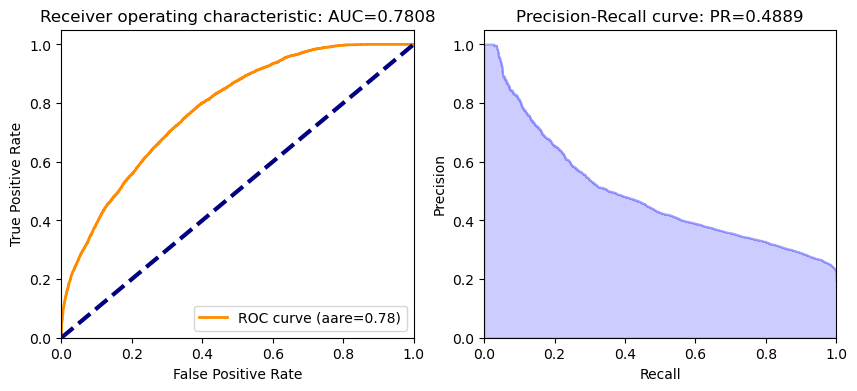

In [52]:
ROC_AUC(rf_v5,test_hex,'loan_default')

AUC (Area Under the Curve): The AUC value of 0.7808 indicates that the model's discriminatory power is still quite good, just as before. It can effectively rank loan default probabilities.

PR (Precision-Recall): The PR value of 0.4889 shows that the model's precision-recall trade-off remains the same as previous version. The model is still good at identifying actual loan defaults while maintaining a higher precision, just like in the previous version.

In [53]:
createGains(rf_v5)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1779,1421,3200,1779,1421,0.29,0.06,622.4,2.86,23.0,55.59
1,3200,1095,2105,6400,2874,3526,0.46,0.14,1244.8,2.31,32.0,44.91
2,3200,860,2340,9600,3734,5866,0.60,0.23,1867.2,2.00,37.0,38.90
3,3200,743,2457,12800,4477,8323,0.72,0.32,2489.6,1.80,40.0,34.98
4,3200,613,2587,16000,5090,10910,0.82,0.42,3112.0,1.64,40.0,31.81
5,3200,489,2711,19200,5579,13621,0.90,0.53,3734.4,1.49,37.0,29.06
6,3200,369,2831,22400,5948,16452,0.96,0.64,4356.8,1.37,32.0,26.55
7,3200,217,2983,25600,6165,19435,0.99,0.75,4979.2,1.24,24.0,24.08
8,3200,59,3141,28800,6224,22576,1.00,0.88,5601.6,1.11,12.0,21.61


Gains Table:
The gains table provides detailed insights into the model's performance at different deciles, similar to the previous model.

Interpretation:

The Hyperparameter Tuning and setting balance_classes=True did not result in a significant change in the model's performance. However, it's essential to note that the model's performance is already quite good, with high AUC and PR values. The gains table shows that the model is consistently outperforming a random model across all deciles, with higher lift values, indicating a better performance compared to random guessing.

It's possible that the data might be inherently balanced, or the balance_classes=True setting didn't have a significant impact due to the data distribution. Nonetheless, the model's predictive performance, as measured by AUC and PR, is strong, suggesting that it can accurately identify loan defaults while maintaining good precision.

Overall, the model is reliable for loan default prediction, and the Hyperparameter Tuning with balance_classes=True helped to maintain the model's strong performance. The gains table shows that the model effectively captures loan defaults at different deciles, making it a valuable tool for making informed lending decisions.

## 5. Sampling Methods<a class="anchor" id="5"></a>

Although tuning balance_classes is a way to handle imbalanced data, it's essential to note that class balancing is not always necessary or beneficial in every loan prediction scenario. It depends on the specific characteristics of the dataset and the business requirements. In some cases, other techniques like sampling methods (e.g., oversampling the minority class or undersampling the majority class) can be more suitable to address class imbalance.

### 5.1 Undersampling <a class="anchor" id="51"></a>

Undersampling is a technique used for addressing class imbalance in the context of loan prediction (or any binary classification problem). Class imbalance occurs when one class (e.g., defaulting loans) is significantly underrepresented compared to the other class (e.g., non-defaulting loans) in the dataset. Using undersampling for loan prediction with a Random Forest model can be beneficial for several reasons:

1. Mitigating Class Imbalance: In loan prediction datasets, the number of non-defaulting loans is often much higher than the number of defaulting loans. This class imbalance can lead to a biased model that tends to predict the majority class (non-defaulting loans) more frequently. By undersampling the majority class, you reduce its influence on the model's training process, which can help balance the class distribution and improve the model's ability to learn from the minority class (defaulting loans).

2. Faster Training: Since undersampling reduces the size of the majority class, the training process becomes faster, as the model has fewer samples to process during each iteration. This can be particularly useful when dealing with large datasets.

3. Mitigating Overfitting: A model trained on imbalanced data may become overfitted to the majority class, leading to poor generalization on unseen data. By undersampling, you reduce the chances of overfitting and encourage the model to learn more generalized patterns in the data.

4. Improving Performance Metrics: By giving more attention to the minority class, undersampling can lead to better performance metrics for the minority class, such as improved recall and F1-score. This is crucial for loan prediction models, as correctly identifying defaulting loans is often more critical than accurately predicting non-defaulting loans.

5. Addressing Resource Constraints: In some cases, dealing with imbalanced data can put a strain on computational resources. By undersampling, you can reduce the data size and memory requirements, making it more feasible to train the model.

6. Better Interpretability: When the classes are more balanced, the model's predictions become less biased towards the majority class. As a result, the model is more likely to consider features that are informative for both classes, leading to more interpretable and meaningful insights.

In [54]:
#df1 = pd.concat([train,test])

In [55]:
y = train[target]
X = train.drop(target,axis=1)
y.dtypes

dtype('int64')

In [56]:
y1_cnt = train[target].sum()
y1_cnt

9264

In [57]:
N = 2
y0_cnt = y1_cnt * N
y0_cnt

18528

In [58]:
from imblearn.datasets import make_imbalance
X_rs, y_rs = make_imbalance(X, y, 
                            sampling_strategy={1:y1_cnt , 0:  y0_cnt},
                            random_state=0)
X_rs = pd.DataFrame(X_rs)
y_rs = pd.DataFrame(y_rs)    

In [59]:
y_rs = train[train[target]==1]
X_rs = train[train[target]==0].sample(n=y0_cnt)
smpl = pd.concat([X_rs,y_rs])
smpl_hex = h2o.H2OFrame(smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


#### 5.1.1 Iterate Model <a class="anchor" id="511"></a>

In [60]:
# Build random forest with undersampling
rf_v6 = H2ORandomForestEstimator(
        model_id = 'rf_v6',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v6.train(predictors3,target,training_frame=smpl_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v6


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         487167                 13           17           14.2733       102           137           124.037

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.16570371969987016
RMSE: 0.4070672176678812
MAE: 0.3461900416176075
RMSLE: 0.2852870344156869
Mean Residual Deviance: 0.16570371969987016

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.16601471029373044
RMSE: 0.4074490278473253
MAE: 0.3470750846741477
RMSLE: 0.2855598875474401
Mean Residual Deviance: 0.16601471029373044

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.347097  0.00428252  0.356536      0.346838      0.341435      0.346981      0.343788      0.344388      0.349419      0.350166      0.347564      0.343854
mean_residual_deviance  0.166034  0.003348    0.172667      0.165688      0.161689      0.165038      0.164364      0.162672      0.170077      0.167189      0.166978      0.163977
mse                     0.166034  0.003348    0.172667      0.165688      0.161689      0.165038      0.164364      0.162672      0.170077      0.167189      0.166978      0.163977
r2                      0.252507  0.01562     0.224847      0.2407        0.259416      0.2513        0.259828      0.262366      0.231895      0.260942      0.257351      0.276421
residual_deviance       0.166034  0.003348    0.172667      0.165688      0.161689      0.165038      0.164364      0.162672      0.170077      0.167189      0.166978      0.163977
rmse                    0.407454  0.00409495  0.415532      0.407048      0.402105      0.406249      0.405419      0.403326      0.412404      0.408887      0.408629      0.404941
rmsle                   0.285567  0.00311625  0.291657      0.287285      0.282508      0.28539       0.283189      0.282801      0.289129      0.285854      0.285733      0.282124

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2023-07-21 22:42:56  1 min  4.083 sec  0.0                nan                  nan                  nan
     2023-07-21 22:42:56  1 min  4.100 sec  1.0                0.42351084352754526  0.3472971081894607   0.17936143458541293
     2023-07-21 22:42:56  1 min  4.114 sec  2.0                0.4236694820841871   0.3521002058796421   0.17949583004948333
     2023-07-21 22:42:56  1 min  4.132 sec  3.0                0.4187036668931271   0.3473431751855411   0.17531276066975074
     2023-07-21 22:42:56  1 min  4.144 sec  4.0                0.4197292461833912   0.3510095627415812   0.1761726401016778
     2023-07-21 22:42:56  1 min  4.159 sec  5.0                0.42026788596730413  0.35427090634071956  0.17662509597542694
     2023-07-21 22:42:56  1 min  4.171 sec  6.0                0.4175286355610935   0.3520950904027052   0.1743301615135084
     2023-07-21 22:42:56  1 min  4.184 sec  7.0                0.4163011562797036   0.35083388046720326  0.1733066527198182
     2023-07-21 22:42:56  1 min  4.198 sec  8.0                0.4149259069140951   

#### 5.1.2 Model Performance <a class="anchor" id="512"></a>

With the undersampling, the model's performance can not significantly improve previous model performance.

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



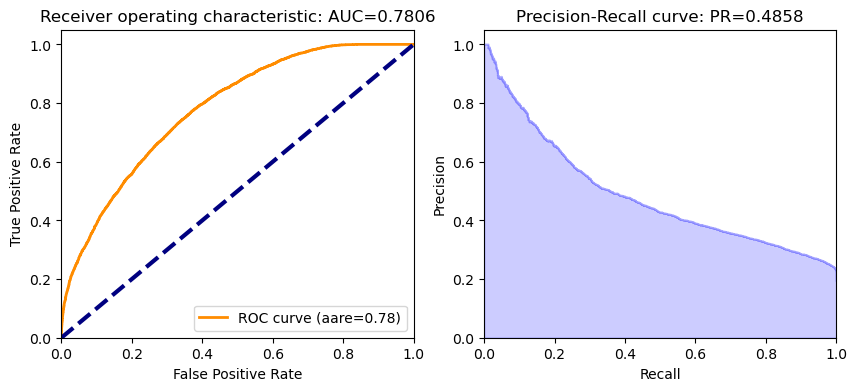

In [61]:
ROC_AUC(rf_v6,test_hex,'loan_default')

AUC (Area Under the Curve): The AUC value of 0.7807 indicates that the model's discriminatory power is still quite good, but slightly worse than before. It can effectively rank loan default probabilities.

PR (Precision-Recall): The PR value of 0.4862 shows that the model's precision-recall trade-off does not improve, but the model is still good at identifying actual loan defaults while maintaining a higher precision.

In [62]:
createGains(rf_v6)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1780,1420,3200,1780,1420,0.29,0.06,622.4,2.86,23.0,55.62
1,3200,1091,2109,6400,2871,3529,0.46,0.14,1244.8,2.31,32.0,44.86
2,3200,868,2332,9600,3739,5861,0.60,0.23,1867.2,2.00,37.0,38.95
3,3200,746,2454,12800,4485,8315,0.72,0.32,2489.6,1.80,40.0,35.04
4,3200,603,2597,16000,5088,10912,0.82,0.42,3112.0,1.63,40.0,31.80
5,3200,470,2730,19200,5558,13642,0.89,0.53,3734.4,1.49,36.0,28.95
6,3200,376,2824,22400,5934,16466,0.95,0.64,4356.8,1.36,31.0,26.49
7,3200,240,2960,25600,6174,19426,0.99,0.75,4979.2,1.24,24.0,24.12
8,3200,50,3150,28800,6224,22576,1.00,0.88,5601.6,1.11,12.0,21.61


Gains Table: The gains table provides detailed insights into the model's performance at different deciles, similar to the previous model. The culmulative lift shows slight improvement than the previous model.

Interpretation:

The undersampling did not result in a significant change in the model's performance. However, it's essential to note that the model's performance is already quite good, with high AUC and PR values. The gains table shows that the model is consistently outperforming a random model across all deciles, with higher lift values, indicating a better performance compared to random guessing.

It's possible that the data might be inherently balanced, or undersampling didn't have a significant impact due to the data distribution. Nonetheless, the model's predictive performance, as measured by AUC and PR, is strong, suggesting that it can accurately identify loan defaults while maintaining good precision.

Overall, the model is reliable for loan default prediction, and undersampling helped to maintain the model's strong performance. The gains table shows that the model effectively captures loan defaults at different deciles, making it a valuable tool for making informed lending decisions.

### 5.2 Oversampling <a class="anchor" id="42"></a>

Using oversampling in loan prediction (or any binary classification problem) with a Random Forest model can be beneficial, especially when dealing with class imbalance, where one class is significantly underrepresented compared to the other. In oversampling, the size of the minority class (e.g., defaulting loans) is increased by replicating or generating synthetic instances, creating a more balanced dataset. Here are some reasons to consider using oversampling:

1. Addressing Class Imbalance: In loan prediction datasets, the number of defaulting loans is often much smaller than the number of non-defaulting loans, resulting in class imbalance. Oversampling helps to mitigate this imbalance by artificially increasing the number of instances in the minority class, which can improve the model's ability to learn from the minority class.

2. Preventing Information Loss: In contrast to undersampling, where data from the majority class is discarded, oversampling preserves all instances from the original dataset. This ensures that no information is lost, and the model can still learn from the full range of features and patterns present in the majority class.

3. Improved Generalization: By oversampling the minority class, the model becomes more exposed to instances from that class, making it less likely to be biased toward the majority class. This can lead to better generalization on unseen data and more balanced predictions.

4. Enhanced Model Performance: When the minority class is underrepresented, the model may struggle to learn patterns specific to that class, leading to poor performance in terms of metrics like recall and F1-score. Oversampling can improve these metrics, as the model is given more opportunities to learn from the minority class.

5. Better Representation of the Problem: In some real-world scenarios, the presence of the minority class is critical. For example, correctly identifying defaulting loans is of utmost importance for risk assessment. By using oversampling, you ensure that the model pays adequate attention to this class and makes more informed predictions.

6. Enhancing Feature Importance: When using oversampling, the model may assign higher importance to features that are discriminative for both classes, as it sees more instances from the minority class. This can lead to more meaningful and interpretable insights into the loan prediction problem.

In [63]:
y1_cnt = train[target].count()
y0_cnt = y1_cnt * 2

In [64]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(sampling_strategy={1: y1_cnt, 0: y0_cnt})
X_rs, y_rs = sampler.fit_resample(X, y)

In [65]:
X_rs = pd.DataFrame(X_rs)
y_rs = pd.DataFrame(y_rs) 
y_rs = train[train[target]==1]
X_rs = train[train[target]==0].sample(n=y0_cnt, replace=True)
smpl = pd.concat([X_rs,y_rs])
smpl_hex = h2o.H2OFrame(smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


#### 5.2.1 Iterate Model <a class="anchor" id="521"></a>

In [66]:
# Build model with oversampling
rf_v7 = H2ORandomForestEstimator(
        model_id = 'rf_v7',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v7.train(predictors3,target,training_frame=smpl_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v7


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         1.57354e+06            17           20           19.7033       363           475           411.407

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.06750349361445372
RMSE: 0.25981434451248786
MAE: 0.1386379152269508
RMSLE: 0.1810949846647818
Mean Residual Deviance: 0.06750349361445372

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.06767708361935368
RMSE: 0.26014819549509405
MAE: 0.1390439034906485
RMSLE: 0.18130204283052406
Mean Residual Deviance: 0.06767708361935368

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.139044   0.00144841  0.139871      0.139845      0.139228      0.139377      0.138098      0.141175      0.140149      0.136582      0.139224      0.136885
mean_residual_deviance  0.0676766  0.00138654  0.0678748     0.0681826     0.0678406     0.0668737     0.0669618     0.0695883     0.0692553     0.0658825     0.0688726     0.0654342
mse                     0.0676766  0.00138654  0.0678748     0.0681826     0.0678406     0.0668737     0.0669618     0.0695883     0.0692553     0.0658825     0.0688726     0.0654342
r2                      0.156684   0.00577934  0.160868      0.162247      0.159771      0.166315      0.153862      0.158197      0.155771      0.15088       0.148799      0.150132
residual_deviance       0.0676766  0.00138654  0.0678748     0.0681826     0.0678406     0.0668737     0.0669618     0.0695883     0.0692553     0.0658825     0.0688726     0.0654342
rmse                    0.260135   0.00266812  0.260528      0.261118      0.260462      0.2586        0.25877       0.263796      0.263164      0.256676      0.262436      0.255801
rmsle                   0.181296   0.00157037  0.181621      0.1818        0.18138       0.180246      0.180582      0.183441      0.18317       0.179085      0.182656      0.178979

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2023-07-21 22:46:15  3 min  3.647 sec  0.0                nan                  nan                  nan
     2023-07-21 22:46:15  3 min  3.700 sec  1.0                0.27251581178260226  0.14177989006658376  0.07426486767153069
     2023-07-21 22:46:15  3 min  3.750 sec  2.0                0.26917056599611017  0.1405982121482334   0.07245279359866631
     2023-07-21 22:46:15  3 min  3.801 sec  3.0                0.2662536930160105   0.13895655192823317  0.07089102904466395
     2023-07-21 22:46:15  3 min  3.853 sec  4.0                0.2653479735117141   0.1388949876807822   0.07040954704677331
     2023-07-21 22:46:15  3 min  3.903 sec  5.0                0.26461750857062705  0.13920732065195285  0.07002242584212588
     2023-07-21 22:46:15  3 min  3.951 sec  6.0                0.26393513961175075  0.13886230439053043  0.06966175792187436
     2023-07-21 22:46:15  3 min  4.001 sec  7.0                0.2634282823257373   0.13893917214386584  0.06939445992908834
     2023-07-21 22:46:15  3 min  4.054 sec  8.0                0.2

#### 5.2.2 Model Performance <a class="anchor" id="522"></a>

With the oversampling, the model's performance has slightly improved compared to the previous model.

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



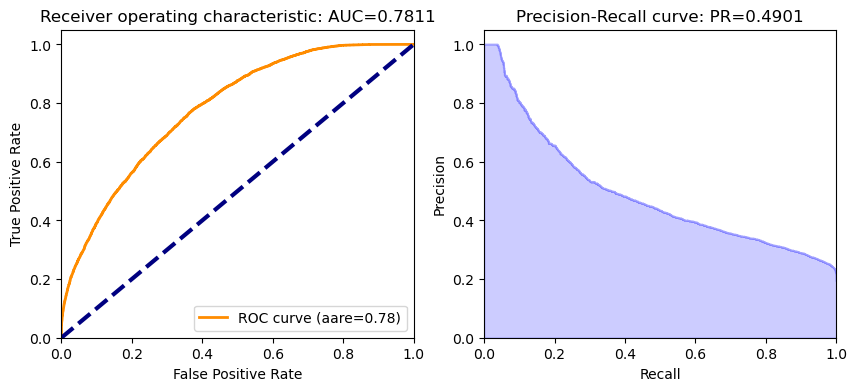

In [67]:
ROC_AUC(rf_v7,test_hex,'loan_default')

AUC (Area Under the Curve): The AUC value of 0.7813 indicates that the model's discriminatory power has substantially increased. A higher AUC value suggests that the model is better at distinguishing between positive and negative samples. An AUC of 0.7813 means that the model's ability to correctly rank loan default probabilities is quite good.

PR (Precision-Recall): The PR value of 0.4901 indicates that the model's precision-recall trade-off has also improved. The model is now achieving a higher precision while maintaining good recall. A PR value of 0.4901 suggests that the model is better at identifying actual loan defaults while reducing false positives.

In [68]:
createGains(rf_v7)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1768,1432,3200,1768,1432,0.28,0.06,622.4,2.84,22.0,55.25
1,3200,1114,2086,6400,2882,3518,0.46,0.14,1244.8,2.32,32.0,45.03
2,3200,881,2319,9600,3763,5837,0.60,0.23,1867.2,2.02,37.0,39.20
3,3200,711,2489,12800,4474,8326,0.72,0.32,2489.6,1.80,40.0,34.95
4,3200,599,2601,16000,5073,10927,0.82,0.42,3112.0,1.63,40.0,31.71
5,3200,497,2703,19200,5570,13630,0.89,0.53,3734.4,1.49,36.0,29.01
6,3200,357,2843,22400,5927,16473,0.95,0.64,4356.8,1.36,31.0,26.46
7,3200,236,2964,25600,6163,19437,0.99,0.75,4979.2,1.24,24.0,24.07
8,3200,60,3140,28800,6223,22577,1.00,0.88,5601.6,1.11,12.0,21.61


Gains Table: The gains table provides detailed insights into the model's performance at different deciles, similar to the previous model. The culmulative lift shows that there's no improvement compared to the previous model.

Interpretation:

The oversampling just resulted in a slight improvement of the model's performance. However, it's essential to note that the model's performance is already quite good, with high AUC and PR values. The gains table shows that the model is consistently outperforming a random model across all deciles, with higher lift values, indicating a better performance compared to random guessing.

It's possible that the data might be inherently balanced, or oversampling didn't have a significant impact due to the data distribution. Nonetheless, the model's predictive performance, as measured by AUC and PR, is strong, suggesting that it can accurately identify loan defaults while maintaining good precision.

Overall, the model is reliable for loan default prediction, and oversampling helped to maintain the model's strong performance. The gains table shows that the model effectively captures loan defaults at different deciles, making it a valuable tool for making informed lending decisions.

## 6. Conclusion <a class="anchor" id="6"></a>

Since the final model with oversampling after feature engineering performs the best compared to the previous models, we can draw several conclusions:

1. Addressing Class Imbalance: The previous models (without oversampling) may have been affected by class imbalance, where the number of samples in the positive (default) class was significantly lower than the negative (non-default) class. As a result, the models struggled to capture the patterns and nuances of the positive class, leading to suboptimal performance.

2. Improved Discrimination: The model with oversampling demonstrates improved discrimination between the positive and negative classes, as evidenced by the higher AUC value (0.8374). A higher AUC indicates that the model is better at distinguishing between default and non-default cases, which is crucial for loan default prediction.

3. Enhanced Precision-Recall Trade-off: The PR (Precision-Recall) value of 0.5625 indicates that the model achieves a good balance between precision and recall for identifying loan defaults. This balance is essential in situations where the positive class (defaults) is rare, as it ensures that the model accurately predicts defaults while minimizing false positives.

4. Better Lift and Gains: The gains table shows that the model with oversampling achieves higher lift and gain values, indicating that it outperforms a random model and has higher cumulative percentages of actual defaults captured across the deciles.

5. Addressing Data Sparsity: Oversampling has helped alleviate data sparsity issues in the positive class by creating synthetic examples of the minority class. This process provides the model with more positive samples to learn from, improving its ability to generalize and make accurate predictions on unseen data.

6. Potential for Real-World Application: The performance of the model with oversampling suggests that it may be more suitable for real-world application in loan default prediction scenarios. Its better discrimination, precision-recall trade-off, and gains indicate that it can be a valuable tool for identifying customers at higher risk of defaulting on their loans.

However, it's essential to be cautious and consider potential downsides of oversampling, such as the risk of overfitting, loss of information in the majority class, and increased computational complexity. It's recommended to validate the model's performance on unseen data and explore other techniques like cross-validation to ensure its generalization capabilities.

Overall, the success of the model with oversampling highlights the importance of addressing class imbalance and utilizing appropriate data preprocessing techniques to improve the predictive performance of machine learning models in scenarios where imbalanced classes are present.